Saving EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023.csv to EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023 (2).csv


/tmp/ipython-input-14-188813207.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-14-188813207.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Train Loss: 0.011007, Val Loss: 0.000313
Epoch 2/20, Train Loss: 0.001021, Val Loss: 0.000071
Epoch 3/20, Train Loss: 0.000603, Val Loss: 0.000077
Epoch 4/20, Train Loss: 0.000442, Val Loss: 0.000118
Epoch 5/20, Train Loss: 0.000335, Val Loss: 0.000149
Epoch 6/20, Train Loss: 0.000248, Val Loss: 0.000147
Epoch 7/20, Train Loss: 0.000247, Val Loss: 0.000084
Epoch 8/20, Train Loss: 0.000196, Val Loss: 0.000034
Epoch 9/20, Train Loss: 0.000169, Val Loss: 0.000115
Epoch 10/20, Train Loss: 0.000158, Val Loss: 0.000069
Epoch 11/20, Train Loss: 0.000178, Val Loss: 0.000066
Epoch 12/20, Train Loss: 0.000145, Val Loss: 0.000030
Epoch 13/20, Train Loss: 0.000109, Val Loss: 0.000047
Epoch 14/20, Train Loss: 0.000121, Val Loss: 0.000033
Epoch 15/20, Train Loss: 0.000110, Val Loss: 0.000037
Epoch 16/20, Train Loss: 0.000102, Val Loss: 0.000101
Epoch 17/20, Train Loss: 0.000110, Val Loss: 0.000286
Epoch 18/20, Train Loss: 0.000085, Val Loss: 0.000032
Epoch 19/20, Train Loss: 0.000099, Va

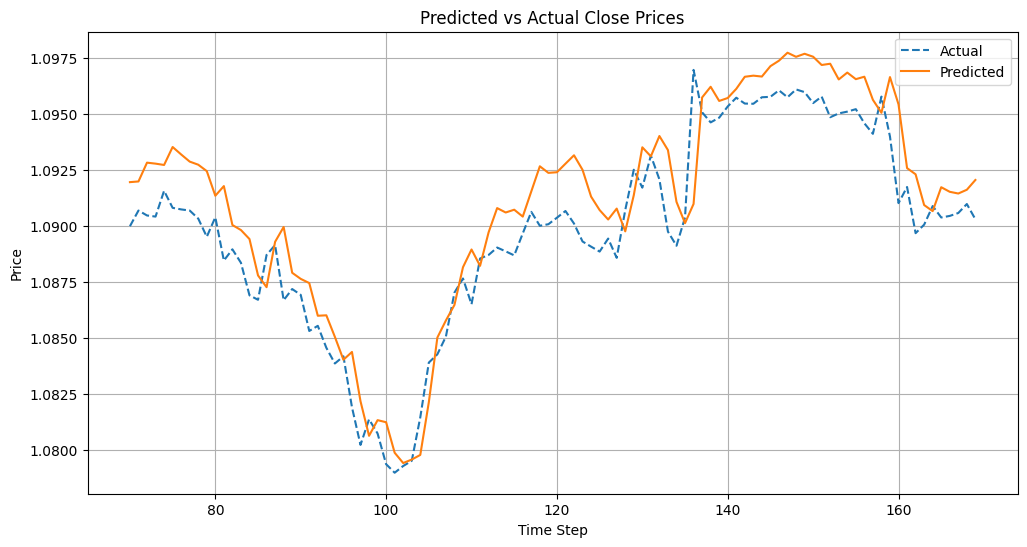

In [ ]:
# -------------------------
# 1. Install Dependencies
# -------------------------
!pip install torch pandas numpy scikit-learn ta matplotlib --quiet

# -------------------------
# 2. Upload CSV File
# -------------------------
from google.colab import files
uploaded = files.upload()

# -------------------------
# 3. Import Libraries
# -------------------------
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import ta
import matplotlib.pyplot as plt

# -------------------------
# 4. Data Loader Functions
# -------------------------
def load_forex_data(csv_file):
    df = pd.read_csv(csv_file)
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
    df.sort_values(by='Gmt time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def add_technical_indicators(df):
    df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['ma_20'] = df['Close'].rolling(window=20).mean()
    df['ma_20_slope'] = df['ma_20'].diff()
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

def select_and_scale_features(df, feature_cols=None):
    if feature_cols is None:
        feature_cols = ['Open', 'High', 'Low', 'Close', 'rsi', 'bb_high', 'bb_low', 'ma_20', 'ma_20_slope']
    data = df[feature_cols].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, feature_cols

# -------------------------
# 5. Dataset Class
# -------------------------
class ForexDataset(Dataset):
    def __init__(self, data, seq_length=30, prediction_length=1, feature_dim=9, target_column_idx=3):
        self.data = data
        self.seq_length = seq_length
        self.pred_length = prediction_length
        self.feature_dim = feature_dim
        self.target_column_idx = target_column_idx

    def __len__(self):
        return len(self.data) - self.seq_length - self.pred_length + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_length]
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.pred_length, self.target_column_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# -------------------------
# 6. Transformer Model
# -------------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=9, num_layers=2, d_model=64, nhead=8, dim_feedforward=256, dropout=0.1, seq_length=30, prediction_length=1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_fc = nn.Linear(feature_size, d_model)
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, prediction_length)

    def forward(self, src):
        batch_size, seq_len, _ = src.shape
        src = self.input_fc(src)
        src = src + self.pos_embedding[:, :seq_len, :]
        src = src.permute(1, 0, 2)
        encoded = self.transformer_encoder(src)
        last_step = encoded[-1, :, :]
        out = self.fc_out(last_step)
        return out

# -------------------------
# 7. Train Function
# -------------------------
def train_transformer_model(model, train_loader, val_loader=None, lr=1e-3, epochs=20, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        mean_train_loss = np.mean(train_losses)
        if val_loader:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    val_output = model(x_val)
                    val_loss = criterion(val_output, y_val)
                    val_losses.append(val_loss.item())
            mean_val_loss = np.mean(val_losses)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {mean_train_loss:.6f}, Val Loss: {mean_val_loss:.6f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {mean_train_loss:.6f}")

    return model

# -------------------------
# 8. Evaluate and Plot
# -------------------------
def evaluate_model(model, test_loader, scaler, feature_cols, target_col_idx, window_width=45, start_index=70, pred_length=1, device='cpu'):
    model.eval()
    real_prices = []
    predicted_prices = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            predictions = model(x_batch).cpu().numpy()
            y_batch = y_batch.cpu().numpy()

            for i in range(len(predictions)):
                dummy_pred = np.zeros((pred_length, len(feature_cols)))
                dummy_real = np.zeros((pred_length, len(feature_cols)))
                dummy_pred[:, target_col_idx] = predictions[i]
                dummy_real[:, target_col_idx] = y_batch[i]

                pred_inv = scaler.inverse_transform(dummy_pred)[:, target_col_idx]
                real_inv = scaler.inverse_transform(dummy_real)[:, target_col_idx]

                predicted_prices.extend(pred_inv)
                real_prices.extend(real_inv)

    real_prices = np.array(real_prices)
    predicted_prices = np.array(predicted_prices)

    mse = np.mean((real_prices - predicted_prices) ** 2)
    mae = np.mean(np.abs(real_prices - predicted_prices))
    print(f"Model Evaluation:\n - MSE: {mse:.4f}, MAE: {mae:.4f}")

    end_index = min(start_index + window_width * pred_length, len(real_prices))
    plt.figure(figsize=(12, 6))
    plt.plot(range(start_index, end_index), real_prices[start_index:end_index], label="Actual", linestyle="--")
    plt.plot(range(start_index, end_index), predicted_prices[start_index:end_index], label="Predicted", linestyle="-")
    plt.title("Predicted vs Actual Close Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# 9. Run Full Pipeline
# -------------------------
# Use the exact filename uploaded
csv_file = list(uploaded.keys())[0]
df = load_forex_data(csv_file)
df = add_technical_indicators(df)
data_scaled, scaler, feature_cols = select_and_scale_features(df)
target_col_idx = feature_cols.index("Close")

seq_length = 30
pred_length = 1
dataset = ForexDataset(data_scaled, seq_length, pred_length, len(feature_cols), target_col_idx)

# Sequential split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = TimeSeriesTransformer(feature_size=len(feature_cols), seq_length=seq_length, prediction_length=pred_length)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model = train_transformer_model(model, train_loader, val_loader, lr=1e-3, epochs=20, device=device)

# -------------------------
# 10. Plot Results
# -------------------------
evaluate_model(trained_model, test_loader, scaler, feature_cols, target_col_idx,
               window_width=100, start_index=70, pred_length=pred_length, device=device)


  Preparing metadata (setup.py) ... done


Saving EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023.csv to EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023.csv


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Train Loss: 0.015652, Val Loss: 0.000080
Epoch 2/20, Train Loss: 0.001076, Val Loss: 0.000138
Epoch 3/20, Train Loss: 0.000649, Val Loss: 0.000476
Epoch 4/20, Train Loss: 0.000457, Val Loss: 0.000052
Epoch 5/20, Train Loss: 0.000329, Val Loss: 0.000259
Epoch 6/20, Train Loss: 0.000271, Val Loss: 0.000057
Epoch 7/20, Train Loss: 0.000218, Val Loss: 0.000203
Epoch 8/20, Train Loss: 0.000189, Val Loss: 0.000177
Epoch 9/20, Train Loss: 0.000162, Val Loss: 0.000068
Epoch 10/20, Train Loss: 0.000151, Val Loss: 0.000096
Epoch 11/20, Train Loss: 0.000126, Val Loss: 0.000083
Epoch 12/20, Train Loss: 0.000091, Val Loss: 0.000032
Epoch 13/20, Train Loss: 0.000113, Val Loss: 0.000031
Epoch 14/20, Train Loss: 0.000093, Val Loss: 0.000141
Epoch 15/20, Train Loss: 0.000092, Val Loss: 0.000029
Epoch 16/20, Train Loss: 0.000083, Val Loss: 0.000086
Epoch 17/20, Train Loss: 0.000082, Val Loss: 0.000078
Epoch 18/20, Train Loss: 0.000074, Val Loss: 0.000066
Epoch 19/20, Train Loss: 0.000061, Va

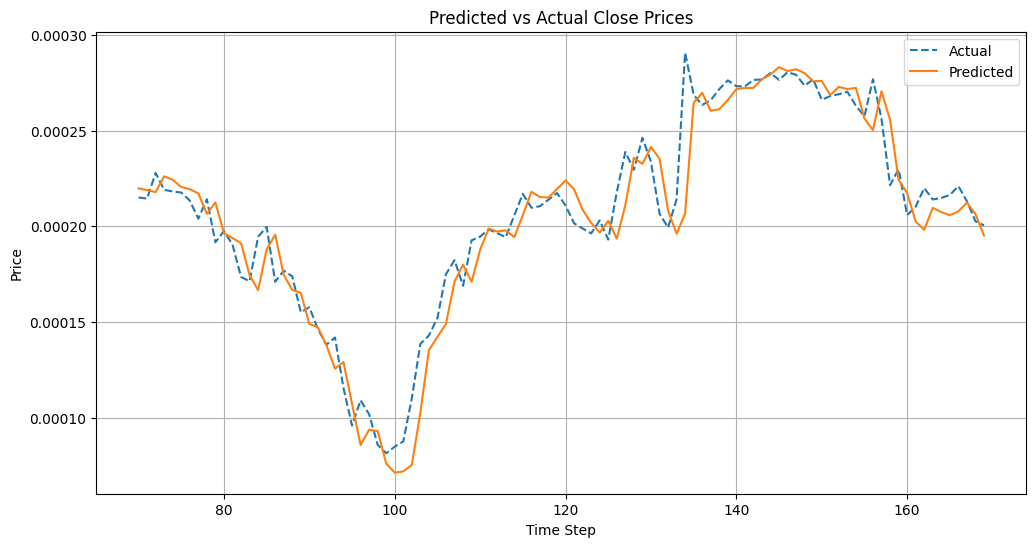

In [1]:
# -------------------------
# 1. Install Dependencies
# -------------------------
!pip install torch pandas numpy scikit-learn ta matplotlib --quiet

# -------------------------
# 2. Upload CSV File
# -------------------------
from google.colab import files
uploaded = files.upload()
if len(uploaded) != 1:
    raise ValueError("Upload exactly one CSV file.")
csv_file = list(uploaded.keys())[0]

# -------------------------
# 3. Import Libraries
# -------------------------
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import ta
import matplotlib.pyplot as plt

# -------------------------
# 4. Data Loader Functions
# -------------------------
def load_forex_data(csv_file):
    df = pd.read_csv(csv_file)
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
    df.sort_values(by='Gmt time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def add_technical_indicators(df):
    df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['ma_20'] = df['Close'].rolling(window=20).mean()
    df['ma_20_slope'] = df['ma_20'].diff()
    df.dropna(inplace=True)  # Drop NaNs to avoid leakage
    return df

def select_and_scale_features(df, feature_cols=None):
    if feature_cols is None:
        feature_cols = ['Open', 'High', 'Low', 'Close', 'rsi', 'bb_high', 'bb_low', 'ma_20', 'ma_20_slope']
    data = df[feature_cols].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, feature_cols

# -------------------------
# 5. Dataset Class
# -------------------------
class ForexDataset(Dataset):
    def __init__(self, data, seq_length=30, prediction_length=1, feature_dim=9, target_column_idx=3, step=1):
        self.data = data
        self.seq_length = seq_length
        self.pred_length = prediction_length
        self.feature_dim = feature_dim
        self.target_column_idx = target_column_idx
        self.step = step  # To handle non-overlapping

    def __len__(self):
        return (len(self.data) - self.seq_length - self.pred_length) // self.step + 1

    def __getitem__(self, idx):
        start = idx * self.step
        x = self.data[start : start + self.seq_length]
        y = self.data[start + self.seq_length : start + self.seq_length + self.pred_length, self.target_column_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# -------------------------
# 6. Transformer Model
# -------------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=9, num_layers=2, d_model=64, nhead=8, dim_feedforward=256, dropout=0.1, seq_length=30, prediction_length=1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_fc = nn.Linear(feature_size, d_model)
        self.pos_embedding = self._generate_positional_encoding(seq_length, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, prediction_length)

    def _generate_positional_encoding(self, seq_len, d_model):
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # (1, seq_len, d_model)

    def forward(self, src):
        batch_size, seq_len, _ = src.shape
        src = self.input_fc(src)
        src = src + self.pos_embedding[:, :seq_len, :]
        src = src.permute(1, 0, 2)  # (seq, batch, d)
        encoded = self.transformer_encoder(src)
        last_step = encoded[-1, :, :]
        out = self.fc_out(last_step)
        return out

# -------------------------
# 7. Train Function
# -------------------------
def train_transformer_model(model, train_loader, val_loader=None, lr=1e-3, epochs=5, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        mean_train_loss = np.mean(train_losses)
        if val_loader:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    val_output = model(x_val)
                    val_loss = criterion(val_output, y_val)
                    val_losses.append(val_loss.item())
            mean_val_loss = np.mean(val_losses)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {mean_train_loss:.6f}, Val Loss: {mean_val_loss:.6f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {mean_train_loss:.6f}")
    torch.save(model.state_dict(), 'forex_model.pth')  # Save model
    return model

# -------------------------
# 8. Evaluate and Plot
# -------------------------
def evaluate_model(model, test_loader, scaler, feature_cols, target_col_idx, window_width=45, start_index=70, pred_length=1, device='cpu'):
    model.eval()
    real_prices = []
    predicted_prices = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            predictions = model(x_batch).cpu().numpy()  # (batch, pred_length)
            y_batch = y_batch.cpu().numpy()  # (batch, pred_length)
            # Inverse transform without dummy for efficiency
            pred_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), len(feature_cols) - 1)), predictions], axis=1))[:, -pred_length:]
            real_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_batch), len(feature_cols) - 1)), y_batch], axis=1))[:, -pred_length:]
            predicted_prices.extend(pred_inv.flatten())
            real_prices.extend(real_inv.flatten())
    real_prices = np.array(real_prices)
    predicted_prices = np.array(predicted_prices)
    mse = np.mean((real_prices - predicted_prices) ** 2)
    mae = np.mean(np.abs(real_prices - predicted_prices))
    print(f"Model Evaluation:\n - MSE: {mse:.4f}, MAE: {mae:.4f}")
    end_index = min(start_index + window_width * pred_length, len(real_prices))
    plt.figure(figsize=(12, 6))
    plt.plot(range(start_index, end_index), real_prices[start_index:end_index], label="Actual", linestyle="--")
    plt.plot(range(start_index, end_index), predicted_prices[start_index:end_index], label="Predicted", linestyle="-")
    plt.title("Predicted vs Actual Close Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# 9. Run Full Pipeline
# -------------------------
df = load_forex_data(csv_file)
df = add_technical_indicators(df)
data_scaled, scaler, feature_cols = select_and_scale_features(df)
target_col_idx = feature_cols.index("Close")
seq_length = 30
pred_length = 1
step_size = pred_length  # Non-overlapping for test
dataset = ForexDataset(data_scaled, seq_length, pred_length, len(feature_cols), target_col_idx, step=1)  # Overlapping for train
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = ForexDataset(data_scaled[train_size + val_size:], seq_length, pred_length, len(feature_cols), target_col_idx, step=step_size)  # Non-overlapping test

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = TimeSeriesTransformer(feature_size=len(feature_cols), seq_length=seq_length, prediction_length=pred_length)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model = train_transformer_model(model, train_loader, val_loader, lr=1e-3, epochs=20, device=device)

# -------------------------
# 10. Plot Results
# -------------------------
evaluate_model(trained_model, test_loader, scaler, feature_cols, target_col_idx, window_width=100, start_index=70, pred_length=pred_length, device=device)